# Making Waves in Water Science: Open Source Tools

Hosted by [**CUAHSI**](https://www.cuahsi.org/cyberseminars/series/making-waves-in-water-science-open-source-tools)

## HyRiver: Hydroclimate Data Retriever

Presenter: **[Taher Chegini](https://cheginit.github.io/), University of Houston**

Email: cheginit@gmail.com

Nov 6th, 2022

## Introduction

The traditional approach for retrieving hydroclimate data from different source was mostly as follows:

- Download entire datasets from various data sources to a local workstation
- Process the data and subset for the region of interest on the workstation
- Store the processed input data and the analyses results locally
- Upload the data to a remote server for publication and sharing

<img src="_static/traditional_data.png" alt="Traditional Approach" style="width: 500px;"/>

Over the last decade using web services have become more common in the geospatial community.

<img src="_static/web-services.png" alt="Web Services" style="width: 500px;"/>

Image [source](https://testautomationresources.com/api-testing/differences-web-services-api/)

HyRiver is a suite of ten open-source (MIT License) Python packages that bridges the gap between (non-technical) hydrologists and complexities of working with web services. [Contribution](https://docs.hyriver.io/contributing.html) of any kind are most welcome.
 
|Package|Description|
|-------|-----------|
|[![Download Stat](https://static.pepy.tech/personalized-badge/pynhd?period=total&left_color=blue&right_color=yellowgreen&left_text=PyNHD)](https://github.com/hyriver/pynhd)|                               Navigate and subset NHDPlus (MR and HR) using web services|
|[![Download Stat](https://static.pepy.tech/personalized-badge/py3dep?period=total&left_color=blue&right_color=yellowgreen&left_text=Py3DEP)](https://github.com/hyriver/py3dep)|Access topographic data through National Map\'s 3DEP web service|
|[![Download Stat](https://static.pepy.tech/personalized-badge/pygeohydro?period=total&left_color=blue&right_color=yellowgreen&left_text=PyGeoHydro)](https://github.com/hyriver/pygeohydro)|Access gNATSGO, NWIS, NID, WQP, HCDN 2009, NLCD, CAMELS, and SSEBop databases|
|[![Download Stat](https://static.pepy.tech/personalized-badge/pydaymet?period=total&left_color=blue&right_color=yellowgreen&left_text=PyDaymet)](https://github.com/hyriver/pydaymet)|Access daily, monthly, and annual climate data via Daymet|
|[![Download Stat](https://static.pepy.tech/personalized-badge/pygridmet?period=total&left_color=blue&right_color=yellowgreen&left_text=PyGridMET)](https://github.com/hyriver/pygridmet)|Access daily climate data via gridMET|
|[![Download Stat](https://static.pepy.tech/personalized-badge/pynldas2?period=total&left_color=blue&right_color=yellowgreen&left_text=PyNLDAS2)](https://github.com/hyriver/pynldas2)|Access hourly NLDAS2 forcing data|
|[![Download Stat](https://static.pepy.tech/personalized-badge/hydrosignatures?period=total&left_color=blue&right_color=yellowgreen&left_text=HydroSignatures)](https://github.com/hyriver/hydrosignatures)|A collection of tools for computing hydrological signatures|
|[![Download Stat](https://static.pepy.tech/personalized-badge/async-retriever?period=total&left_color=blue&right_color=yellowgreen&left_text=AsyncRetriever)](https://github.com/hyriver/async-retriever)|High-level API for asynchronous requests with persistent caching|
|[![Download Stat](https://static.pepy.tech/personalized-badge/pygeoogc?period=total&left_color=blue&right_color=yellowgreen&left_text=PyGeoOGC)](https://github.com/hyriver/pygeoogc)|Send queries to any ArcGIS RESTful-, WMS-, and WFS-based services|
|[![Download Stat](https://static.pepy.tech/personalized-badge/pygeoutils?period=total&left_color=blue&right_color=yellowgreen&left_text=PyGeoUtils)](https://github.com/hyriver/pygeoutils)|Utilities for manipulating geospatial, (Geo)JSON, and (Geo)TIFF data|

Here's a chart of HyRiver packages dependencies:

<img src="_static/hyriver_deps_nt.png" alt="HyRiver Interdependencies" style="width: 500px;"/>

## An Application in Hydrological Modeling

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from hymod import HYMOD
from scipy import optimize

import pydaymet as daymet
import pygeohydro as gh
import pygeoutils as geoutils
from pygeohydro import NWIS
from pynhd import NLDI

We use HyRiver packages to get the required input data for hydrological modeling of a watershed. We use [PyDaymet](https://github.com/cheginit/pydaymet) to get precipitation and potential evapotranspiration and [PyGeoHydro](https://github.com/cheginit/pygeohydro) to get streamflow observations and soil storage capcity. Then, we use an implementation of the [HYMOD](https://piahs.copernicus.org/articles/368/180/2015/piahs-368-180-2015.pdf) model for our watershed analysis. The source for the model can be found in [hymod.py](https://github.com/cheginit/HyRiver-examples/blob/main/notebooks/hymod.py) file.

<img src="_static/hymod-flowchart.png" alt="HYMOD Flowchart" style="width: 500px;"/>

First, we use the CAMELS dataset to select a natural watershed with no significant snow since this implementation of HYMOD does not have a snow component.

In [2]:
camels_basins, camels_qobs = gh.get_camels()

In [3]:
stations = camels_basins[
    (camels_basins.area_gages2 > 300)
    & (camels_basins.area_gages2 < 500)
    & (camels_basins.frac_snow < 0.1)
]
station = stations.iloc[0].name

Next, we get more information about our selected watershed drainage area geometry using [PyNHD](https://github.com/cheginit/pynhd) and [PyGeoHydro](https://github.com/cheginit/pygeohydro). To ensure that the station is located at the outlet of the watershed, we set `split_catchment` flag to `True` to split the catchment at the station's location.

In [4]:
dates = ("2003-01-01", "2012-12-31")
nwis = NWIS()

basin = NLDI().get_basins(station, split_catchment=True)
info = nwis.get_info({"site": station})
info

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd,hcdn_2009,geometry
0,USGS,01666500,"Robinson River Near Locust Dale, VA",ST,38.32513,-78.095556,U,NAD83,282.64,0.08,NAVD88,02080103,True,POINT (-78.09556 38.32513)


Let's check the area of the watershed and plot it.

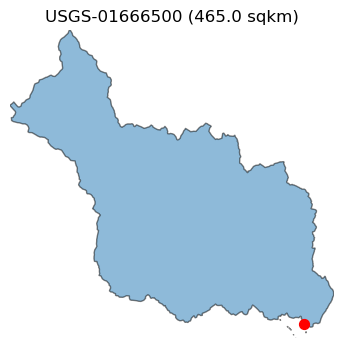

In [5]:
area_sqm = basin.to_crs(basin.estimate_utm_crs()).area.values[0]
ax = basin.plot(figsize=(9, 4), alpha=0.5, edgecolor="black")
info.plot(ax=ax, markersize=50, color="red")
ax.set_title(f"USGS-{station} ({area_sqm * 1e-6:.1f} sqkm)")
# ctx.add_basemap(ax, crs=basin.crs)
ax.margins(0)
ax.set_axis_off()
ax.figure.savefig(Path("_static", "hymod.png"), dpi=300, bbox_inches="tight", facecolor="w")

Now, we get some information about this station and then retrieve streamflow observations within the period of our study for calibrating the model from PyGeoHydro. Since HYMOD's output is in mm/day we can either set the `mmd` flag of `NWIS.get_streamflow` to `True` to return the data in mm/day instead of the default cms, or use `area_sqm` that we obtained previously to do the conversion. Note that these two methods might not return identical results since `NWIS.get_streamflow` uses GagesII and NWIS to get the drainage area while here we used NLDI to obtain the area and these two are not always the same.

In [6]:
qobs = nwis.get_streamflow(station, dates)
qobs = qobs * (1000.0 * 24.0 * 3600.0) / area_sqm

We can check the difference in areas produced by these two methods as follows:

In [7]:
area_nwis = nwis._drainage_area_sqm(info, "dv")
f"NWIS: {area_nwis.iloc[0] * 1e-6:.1f} sqkm, NLDI: {area_sqm * 1e-6:.1f} sqkm"

'NWIS: 468.5 sqkm, NLDI: 465.0 sqkm'

PyDaymet can compute Potential EvapoTranspiration (PET) at daily timescale using three methods: `penman_monteith`, `priestley_taylor`, and `hargreaves_samani`. Let's use `hargreaves_samani` and get the data for our study period.

In [8]:
clm = daymet.get_bygeom(basin.geometry.iloc[0], dates, variables="prcp", pet="hargreaves_samani")

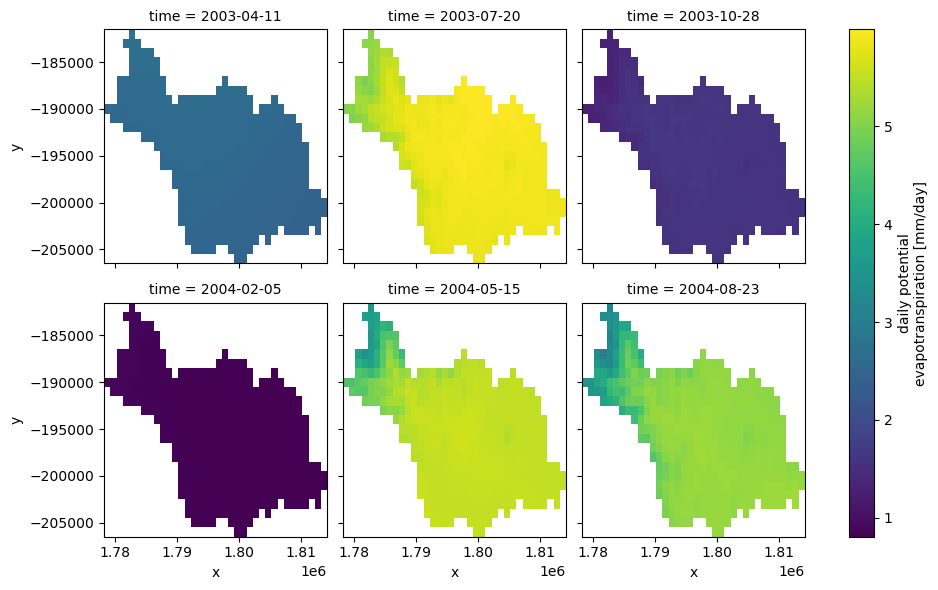

In [9]:
_ = (
    clm.where(clm.pet > 0)
    .pet.isel(time=range(100, 700, 100))
    .plot(x="x", y="y", row="time", col_wrap=3)
)

Since our HYMOD implementation is a lumped model, we need to take the areal average of the input precipitation and potential evapotranspiration data. Moreover, since Daymet's calendar doesn't have leap years (365-day year), we need to make sure that the time index of the input streamflow observation matches that of the climate data.

In [10]:
clm_df = clm.mean(dim=["x", "y"]).to_dataframe()[["prcp", "pet"]]
clm_df.index = pd.to_datetime(clm_df.index.date)

qobs.index = pd.to_datetime(qobs.index.to_series().dt.tz_localize(None).dt.date)
idx = qobs.index.intersection(clm_df.index)
qobs, clm_df = qobs.loc[idx], clm_df.loc[idx]

We can use soil data to estimate $C_{max}$ parameter of HYMOD model instead of calibrating it. 

In [11]:
geometry = basin.geometry.iloc[0]
crs = basin.crs

porosity = gh.soil_properties("por").porosity
porosity = geoutils.xarray_geomask(porosity, geometry, crs)
porosity = porosity.where(porosity > porosity.rio.nodata)
porosity = porosity.rio.write_nodata(np.nan)

thickness = gh.soil_gnatsgo("tk0_999a", geometry, crs).tk0_999a
thickness = thickness.where(thickness < 2e6, drop=False) * 10
thickness = thickness.rio.write_nodata(np.nan)
thickness = thickness.rio.reproject_match(porosity, resampling=5)

storage = porosity * thickness * 1e-3
storage = storage.rio.write_nodata(np.nan)
cmax = storage.mean().compute().item()

Now, let's use `scipy` to calibrate the model parameters using 70% of the observation data and Kling-Gupta Efficiency as the objective function.

In [12]:
cal_idx = int(0.7 * clm_df.shape[0])
model = HYMOD(clm_df.iloc[:cal_idx], qobs.iloc[:cal_idx].squeeze(), cmax, 1)
bounds = {
    # "c_max": (1, 1500),  # Maximum storage capacity
    "b_exp": (0.0, 1.99),  # Degree of spatial variability of the soil moisture capacity
    "alpha": (0.01, 0.99),  # Factor for dividing flow to slow and quick releases
    "k_s": (0.01, 0.14),  # Residence time of the slow release reservoir
    "k_q": (0.14, 0.99),  # Residence time of the quick release reservoir
}
results = optimize.differential_evolution(
    model.fit,
    list(bounds.values()),
    popsize=200,
    seed=1,
)
dict(zip(bounds, results.x.round(2).tolist()))

{'b_exp': 0.33, 'alpha': 0.99, 'k_s': 0.14, 'k_q': 0.65}

With the obtained calibrated parameters, we can validate the model over the validation period (30%) of the streamflow observation.

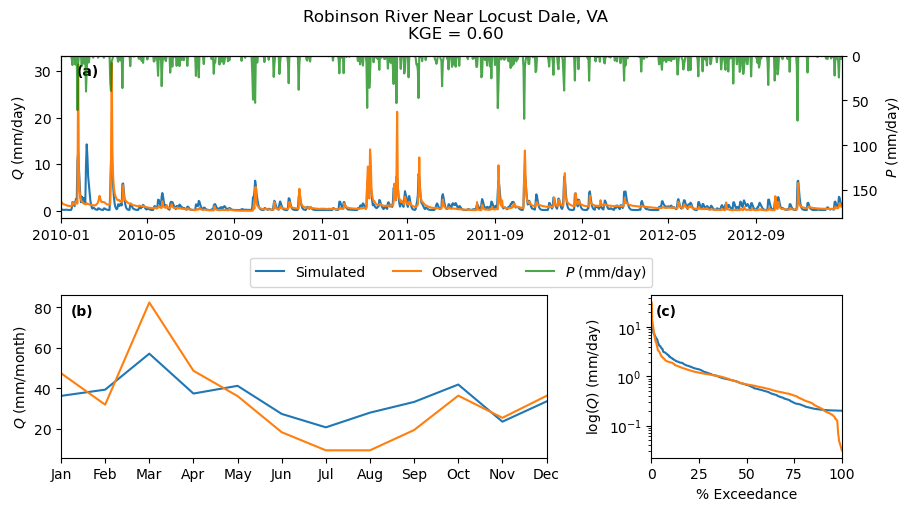

In [13]:
warm_up = clm_df.iloc[:cal_idx].index.year.unique().shape[0]
model = HYMOD(clm_df, qobs.squeeze(), cmax, warm_up)
qsim = model.simulate(results.x)
kge = -model.fit(results.x)
name = info.station_nm.values[0]
index = qobs.iloc[cal_idx:].index
discharge = pd.DataFrame(
    {"Simulated": qsim[model.cal_idx], "Observed": model.qobs[model.cal_idx]}, index=index
)
_ = gh.plot.signatures(
    discharge,
    clm_df.iloc[cal_idx:].prcp,
    title=f"{name}\nKGE = {kge:.2f}",
)